# Goal

The goal is to create a model to predict median house prices in a suburb of Boston in the 1970s. The dataset has 506 entries, split between 404 training samples and 102 test samples. 

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
# median house price in 1000 dollars
train_targets[0]

15.2

## Featurewise Normalization

In [5]:
from typing import Tuple


def normalize(training_data: np.array, test_data: np.array) -> Tuple[np.array, np.array]:
    x_train = np.copy(training_data)
    x_test = np.copy(test_data)
    
    colwise_mean = x_train.mean(axis=0)
    colwise_sd = x_train.std(axis=0)
    
    x_train = (x_train - colwise_mean) / colwise_sd
    x_test = (x_test - colwise_mean) / colwise_sd
    
    return x_train, x_test

## Model

In [6]:
from keras import models
from keras import layers

def build_model(num_features):
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(num_features,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [7]:
from typing import List


def k_fold_crossvalidation(train_data: np.array, 
                           train_targets: np.array, 
                           k: int, 
                           num_epochs: int = 100) -> List[float]:
    num_val_samples = len(train_data) // k
    all_scores = []
    
    
    for i in range(k):
        print(f'processing fold {i}')
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                             train_data[(i + 1) * num_val_samples:]], 
                                            axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                                train_targets[(i + 1) * num_val_samples:]], 
                                               axis=0)

        model = build_model(num_features=train_data.shape[1])                  
        
        history = model.fit(partial_train_data, 
                            partial_train_targets, 
                            epochs=num_epochs, 
                            validation_data=(val_data, val_targets),
                            batch_size=1, 
                            verbose=0)
        
        # val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
        mae_history = history.history['val_mae']
        
        all_scores.append(mae_history)
    
    return all_scores

In [8]:
x_train, x_test = normalize(train_data, test_data)

In [9]:
scores = k_fold_crossvalidation(x_train, train_targets, k=4, num_epochs=200)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [10]:
scores

[[3.7610924243927,
  2.867982864379883,
  2.653700828552246,
  2.466275453567505,
  2.4262495040893555,
  2.445152997970581,
  2.556215286254883,
  2.6057863235473633,
  2.1555421352386475,
  2.3171355724334717,
  2.2561073303222656,
  2.197618007659912,
  2.1086578369140625,
  2.12789249420166,
  2.4949886798858643,
  2.0264081954956055,
  2.087937831878662,
  2.128373146057129,
  2.4290616512298584,
  2.42873477935791,
  2.2389516830444336,
  2.0091731548309326,
  2.092099905014038,
  2.073702096939087,
  2.3371033668518066,
  2.2864394187927246,
  1.9788788557052612,
  2.1112570762634277,
  2.2409238815307617,
  1.920259952545166,
  2.078188180923462,
  2.6255764961242676,
  2.1298818588256836,
  2.0312252044677734,
  2.3137190341949463,
  2.1393232345581055,
  1.9675835371017456,
  1.9446567296981812,
  1.9226338863372803,
  2.4337165355682373,
  2.093676805496216,
  2.228882312774658,
  1.9244053363800049,
  2.1169891357421875,
  2.491405725479126,
  1.981873631477356,
  1.9118800

In [11]:
np.mean(scores)

2.5849956043064592

## Average MAE by Epoch

In [15]:
def plot(av_mae):
    plt.plot(range(1, len(av_mae) + 1), av_mae)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

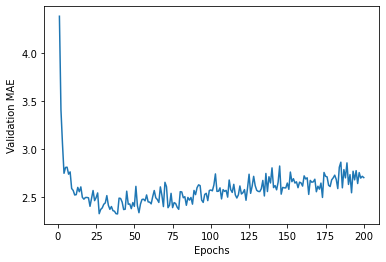

In [16]:
num_epochs = 200

average_mae_history = [np.mean([x[i] for x in scores]) for i in range(num_epochs)]
plot(average_mae_history)

## Smoothing the Average MAE

In [21]:
import pandas as pd

av_mae_series = pd.Series(average_mae_history)[10:]

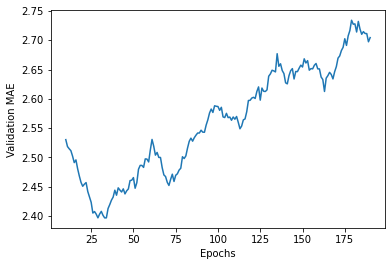

In [26]:
av_mae_smoothed = av_mae_series.rolling(window=10).mean()
plot(av_mae_smoothed)